# Amazon Recommender System for Video Games
Data: https://jmcauley.ucsd.edu/data/amazon/ (video games data set)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# header: (user,item,rating,timestamp)
df = pd.read_csv('ratings_Video_Games.csv', names=['user','item','rating','timestamp'])

In [3]:
df.head()

,user,item,rating,timestamp
0,AB9S9279OZ3QO,0078764343,5.0,1373155200
1,A24SSUT5CSW8BH,0078764343,5.0,1377302400
2,AK3V0HEBJMQ7J,0078764343,4.0,1372896000
3,A10BECPH7W8HM7,043933702X,5.0,1404950400
4,A2PRV9OULX1TWP,043933702X,5.0,1386115200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324753 entries, 0 to 1324752
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1324753 non-null  object 
 1   item       1324753 non-null  object 
 2   rating     1324753 non-null  float64
 3   timestamp  1324753 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 40.4+ MB


## Data Preprocessing

In [5]:
# drop time stamp
df.drop('timestamp',inplace=True, axis=1)

## Data Exploration

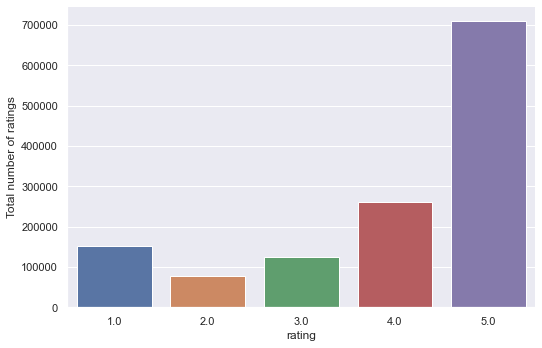

In [289]:
sns.catplot("rating", data=df, aspect=1.5, kind='count')
plt.ylabel("Total number of ratings")
plt.show()

In [7]:
# unique users and products
print("Total data")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of products  :", len(np.unique(df.item)))

Total data
--------------------------------------------------

Total no of ratings : 1324753
Total No of Users   : 826767
Total No of products  : 50210


In [8]:
ratings_per_user = df.groupby('user')['rating'].count().sort_values(ascending=False)
ratings_per_user.head()

user
A3V6Z4RCDGRC44    880
A3W4D8XOGLWUN5    817
AJKWF4W7QD4NS     797
A2QHS1ZCIQOL7E    521
A2TCG2HV1VJP6V    474
Name: rating, dtype: int64

In [9]:
ratings_per_user.describe()

count    826767.000000
mean          1.602329
std           3.239171
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         880.000000
Name: rating, dtype: float64

Most users leave only 1 rating

In [10]:
# how many users leave more than 30?
print('Num of users ranking more than 30 products: {}\n'.format(sum(ratings_per_user >= 30)))

Num of users ranking more than 30 products: 913



## Recommender Systems

### Popularity Based System

This method will recommend to the user whatever is most popular. It doesn't take into consideration anything about the user. It essentially just assumes the user will be interested in it because others are interested in it.

In [29]:
# We will start by making a data frame of the most "popular" products
# "Popular" will be defined as having 30 or more reviews
# Make dataframe containing only products with 30 or more ratings

df_pop_prods = df.groupby("item").filter(lambda x: x['rating'].count() >= 30)

In [31]:
print('Percentage of products used: {:.0%}'.format(len(np.unique(df_pop_prods.item))/len(np.unique(df.item))))

Percentage of products used: 16%


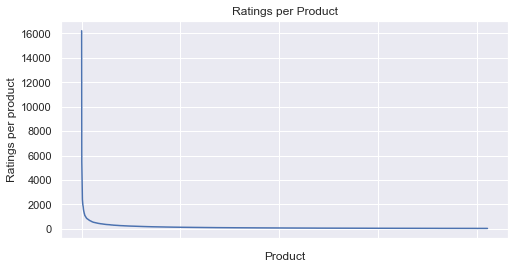

In [32]:
ratings_per_prod = df_pop_prods.groupby(by='item')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(ratings_per_prod.values)
plt.title('Ratings per Product')
plt.xlabel('Product')
plt.ylabel('Ratings per product')
ax.set_xticklabels([])

plt.show()

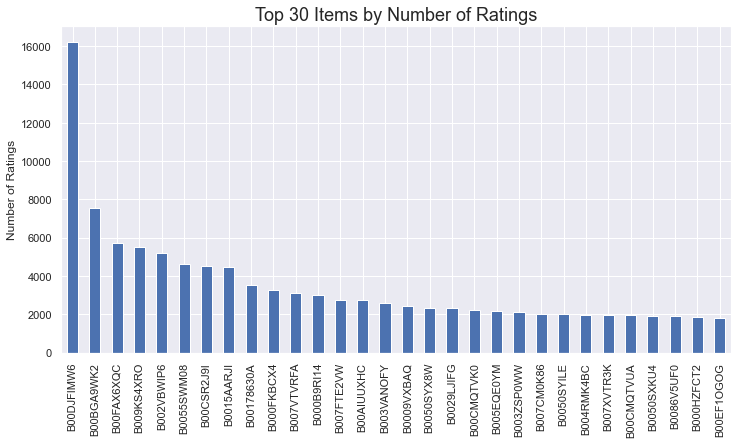

In [33]:
# recommender based on popular products would yield results below
popular_products = pd.DataFrame(df_pop_prods.groupby('item')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar", figsize=(12,6), legend=False)
plt.title('Top 30 Items by Number of Ratings', size=18)
plt.xlabel(None)
plt.ylabel('Number of Ratings')
plt.show()

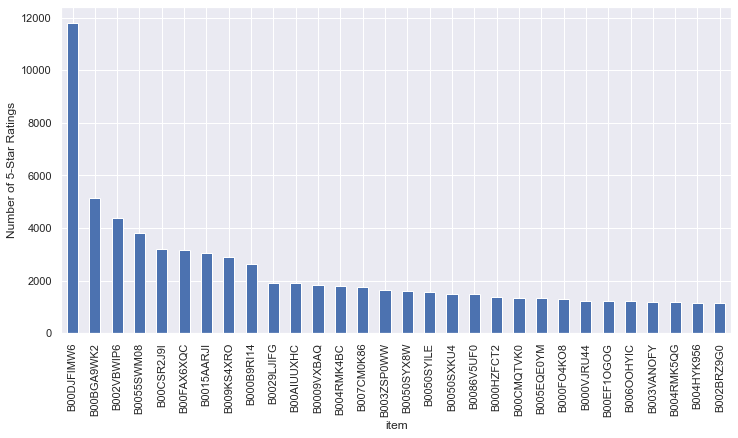

In [36]:
# recommender based on most 5-star ratings yields results below 
top_products = pd.DataFrame(df_pop_prods[df_pop_prods['rating'] == 5.0].groupby('item')['rating'].count())
highest_rated = top_products.sort_values('rating', ascending=False)
highest_rated.head(30).plot(kind = "bar", figsize=(12,6), legend=False)
plt.ylabel('Number of 5-Star Ratings')
plt.show()

## Collaborative Filtering (CF) System

This method will recommend products to the user based on ratings from like-minded users. This is accomplished by creating a user-item association matrix. Recommendations are made based on what would fill in that matrix. 

### Nearest Neighbor CF
There are a few different types of CF methods. One of the most common is the Nearest Neighbor method, which itself has two varieties. First, there is the user-based algorithm which recommends items based on that user's similarity to another user. In essence, the algorithm will recommend products that the similar user has bought (or in this case rated highly). The other method is called item-based. This method acts similarly to the user-based but instead of finding the similarites between users, it finds the similarites between items. The algorithm will recommend to a user items that are deemed similar to the one(s) the user has purchased (in this case it would recommend products similar to the ones the user has rated highly). We will use both below.

#### Import Libraries

In [220]:
# using the surprise library built for recommendation systems
from surprise import KNNWithMeans, SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
# import os
from surprise.model_selection import train_test_split, GridSearchCV

#### Item-Based Model

In [ ]:
# further filter the popular products dataset down
# filter to 30 or more reviews and users that have reviewed 5 or more items
# need to loop through until both conditions are satisfied (if the dataframe gets too small then break loop)
df2 = df_pop_prods # initialize df2 as popular products
while (df2.user.value_counts().min() < 5 or df2.item.value_counts().min() < 30) and len(df2) >= 5000:
    df1 = df2.groupby("item").filter(lambda x: x['rating'].count() >= 30)
    df2 = df1.groupby("user").filter(lambda x: x['rating'].count() >= 5)

In [138]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df2,reader)

In [139]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [140]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [141]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [142]:
test_pred[1]

Prediction(uid='A27ADCSD15F3GL', iid='B0016BVY7U', r_ui=1.0, est=1, details={'actual_k': 1, 'was_impossible': False})

In [143]:
# get RMSE
# print("Item-based Model : Test Set")
print('RMSE: {:.4f} | MAE: {:.4f}'.format(accuracy.rmse(test_pred, verbose=False), accuracy.mae(test_pred, verbose=False)))

RMSE: 1.1253 | MAE: 0.7894


#### User-Based Model

In [144]:
# shrink the dataset to include only users with 30 or more item reviews
df_active_users = df.groupby("user").filter(lambda x: x['rating'].count() >= 30)

In [145]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_active_users,reader)

#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [221]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

# run the trained model against the testset
test_pred = algo.test(testset)

# get RMSE
# print("Item-based Model : Test Set")
print('RMSE: {:.4f} | MAE: {:.4f}'.format(accuracy.rmse(test_pred, verbose=False), accuracy.mae(test_pred, verbose=False)))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.1650 | MAE: 0.8225


### Model Based Collaborative Filtering

#### SVD Model from Surprise Library

In [ ]:
# # Training SVD takes about 30 minutes
# # train SVD instead of KNNWithMeans
# param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6], 'biased': 'False'}

# gs = GridSearchCV(SVD, param_grid, measures=['rmse','mae'], cv=3)
# gs.fit(data)

# # print out best score
# print(gs.best_score['rmse'])

# # print parameters
# print(gs.best_params['rmse'])

# After running above code for SVD
# RMSE 1.2347587555445623
# {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4, 'biased': 'F'}

In the cell below, we will train an SVD model then use it to return the top 3 recommended products for each user. We will then examine the outputs for a user and see if they make sense.

In [235]:
from collections import defaultdict
# define the return top n function
def get_top_n(predictions, n=5):
    
    # first map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid,est))
    
    # next sort the predictions by user and retrieve the k highest ones
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

In [236]:
# make a copy of the data set for the most reviewed products and most active users
svd_data = df2.copy()

#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(svd_data,reader)

#Splitting the dataset
trainset = data.build_full_trainset()

# build the model (parameters used were found from the grid search above ^^^)
svd_model = SVD(n_epochs=10, lr_all=0.005,reg_all=0.4, biased='F')
svd_model.fit(trainset)

# predict ratings for all user-item pairs that are not in the trainset
testset = trainset.build_anti_testset()
predictions = svd_model.test(testset)

top_n = get_top_n(predictions, n=3)

In [263]:
# examine top 3 products for user AS210VKE6OUJK 

liked_item = svd_data[svd_data['user'] == 'AS210VKE6OUJK'].sort_values('rating', ascending=False).iloc[0]['item']

print('Sample User: AS210VKE6OUJK')
print('Liked item: ', liked_item)

print('Top 3 recommended items:',top_n.get('AS210VKE6OUJK'))

Sample User: AS210VKE6OUJK
Liked item:  B00002DHEV
Top 3 recommended items: [('B00002STXN', 4.647181880793951), ('B0050SX0UY', 4.630170003619608), ('B004RMK4BC', 4.603974142903263)]


In the above example, the user's highest rated item is a Nintendo 64 console </text>
<img src="https://m.media-amazon.com/images/I/61j0V37zKcL._AC_UY327_FMwebp_QL65_.jpg" width="200" height="200" />

The top 3 recommended items are The Legend of Zelda: A Link to the Past, Tearaway, and a $20 PlayStation Store Gift Card.
<img src="https://m.media-amazon.com/images/I/513hbHV0T4L._AC_UY327_FMwebp_QL65_.jpg" width="200" height="200" />
<img src="https://m.media-amazon.com/images/I/51-C1daB9rL._AC_UY327_FMwebp_QL65_.jpg" width="200" height="200" />
<img src="https://m.media-amazon.com/images/I/71qiIGHeN5L._AC_UL480_FMwebp_QL65_.jpg" width="200" height="200" />

The first recommended product seems to make sense. It is suggesting a retro gaming product. The next 2 products seem to be more disconnected from the one rated product we sampled from the user. It's possible other products the user has liked are related to playstation games. If we put this into production, we could test the strength of the recommender system by comparing the actual user rating of the recommended products (assuming at some point the user rates them). 